# Bias Detection in News Headlines: Emotion, Leaning & Interpretability

This notebook explores rhetorical bias in news headlines by analyzing political leanings and emotional framing through a structured, multi-stage NLP pipeline.

To compare perfomance and explore, to what extend additional features like emotion and political leaning can improve model classification of rhetorical bias, we trained two models: one text-only and one feature-enhanced.

We classified emotion and political leaning as well as politicization on a word- and document-level to extract interpretable features for model training, and analyzed possible correations (linear and non-linear) to reveal structural patterns of bias across headlines.

Both models were the `microsoft/deberta-v3-base` with Stratified K-Fold Cross Validation and random oversampling, to ensure balanced class representation across folds and mitigating the effects of class imbalance.

The workflow is modular, reproducible, and designed to support both statistical insight and downstream explainability.

## 1.1 Environment Set up (Colab only)

To run this notebook in Google Colab, we included the following commands for cloud environments.

In [ ]:
!pip install accelerate
!pip install transformers datasets torch --quiet

## 1.2 Library imports and initialization

This section loads all core libraries required for data handling, model training, evaluation, and linguistic analysis.

- **Core libraries**: `pandas`, `numpy`, `tqdm` for data manipulation and progress tracking , `os` for file and path management, `seaborn` and `matplotlib` for visualizing distributions, correlations, and model performance metrics
- **Transformers & NLP**: Hugging Face's `transformers`, `datasets`, and `torch` for model fine-tuning and inference
- **Statistical analysis**: `scipy.stats.chi2-contingency` for testing independence between categorical variables
- **Evaluation**: `sklearn` metrics for classification performance (such as `accuracy_score`, `f1_score`, `precision_score` and `recall_score`), as well as `StratifiedKFold` for splitting datasets
- **Linguistic analysis**: `spaCy` for part-of-speech tagging and syntactic feature extraction

The `spaCy` model `en_core_web_sm` was loaded for downstream linguistic feature engineering.

In [21]:
# Core libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# NLP and Transformers
import torch
from huggingface_hub import login
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    Trainer,
    TrainingArguments,
    set_seed,
    DataCollatorWithPadding,
    RobertaTokenizer,
    DebertaV2Tokenizer,
    DebertaV2ForSequenceClassification,
    TextClassificationPipeline
)
from datasets import load_dataset, Dataset, DatasetDict

# Statistical analysis
from scipy.stats import chi2_contingency

# Evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Linguistic analysis (optional)
import spacy
nlp = spacy.load("en_core_web_sm")

# Colab integration and file handling
from google.colab import files
import pickle

## 2. Data import

In this section, we loaded the annotated dataset and selected a **subset of relevant columns** to focus on headline text, bias label and key metadata:

- **text**: the raw headline
- **label**: annotated bias category (biased, non-biased)
- **topic**: headline type (e.g. environment, gender,...)
- **factual**: factuality label (e.g. entirely factual,...)
- **type**: perceived ideological leaning of the headline (left, center, right)

We also dropped any rows with missing values in the text or label columns to ensure clean input for downstream analysis and model training.

To simplify downstream modeling and evaluation, we converted the original **bias labels into a binary format**:

- `biased` → `1`  
- `unbiased` → `0`

This binary label (`bias_binary`) enabled clearer performance metrics when comparing biased vs. unbiased headline detection.

In [22]:
import kagglehub
path = kagglehub.dataset_download("timospinde/mbic-a-media-bias-annotation-dataset")
df = pd.read_excel(os.path.join(path, "annotations.xlsx"))



Using Colab cache for faster access to the 'mbic-a-media-bias-annotation-dataset' dataset.


In [23]:
# Select relevant columns and drop lines with missing values
df_subset = df[["text", "label", "type", "factual", "political_ideology"]].copy()
df_subset = df_subset.dropna(subset=["text", "label"])

In [24]:
# Convert bias labels into a binary format
df_subset["bias_binary"] = df_subset["label"].apply(lambda x: 1 if x.lower() == "biased" else 0)

In [25]:
df_subset.head()

,text,label,type,factual,political_ideology,bias_binary
0,The transgender effort to suppress any recogni...,Non-biased,right,Entirely factual,7,0
1,Radical Virginia Citizens Defense League has o...,Non-biased,left,Expresses writer’s opinion,7,0
2,Miller is the architect of President Donald Tr...,Non-biased,left,Somewhat factual but also opinionated,7,0
3,"The House Democrats’ 1,400-page coronavirus re...",Non-biased,right,Expresses writer’s opinion,7,0
4,A specter is haunting the West; our elites see...,Non-biased,right,Expresses writer’s opinion,7,0


## 3. Explorative data analysis (EDA)
In this section, we explored the structure and distribution of key variables in the full dataset (`df`), including:

- Frequency of bias labels (biased, non-biased)
- Dynamics of bias and factuality
- Frequency of bias types (left, center, right)
- Overview of media outlets in the dataset
- Overview of topics in the dataset
- Bias dynamics across topical categories in the dataset
- Overview of political ideology of annotators
- Bias perception across annotator groups
- Overview of average length of headlines

The goal was to identify patterns, validate assumptions, and guide feature selection for the bias classification model.

### 3.1 Spread of bias labels
First, the distribution of bias labels in the annotated dataset is shown in the bar graph below. It shows the frequency of each label category (`biased`, `non-biased`), helpign to assess class balance and potential imbalances.

The label distribution was crucial for designing appropriate sampling strategies, choosing evaluation metrics and interpreting model performance in context.

The bar graph below revealed a slight **class imbalance** in the dataset, with more headlines labeled as "biased" (around 10,000) than "non-biased" (around 8,000). While the difference is not extreme, it is important to recognize possible implications for the model training and evaluation:

An imbalanced label distribution can lead models to **overpredict the majority class**, so it's advisable to use metrics like macro-F1 and consider techniques such as stratified sampling and class weighting to ensure fair performance.

In [ ]:
df["label"].value_counts()

,count
label,
Biased,10651
Non-biased,7124


<Axes: title={'center': 'Distribution of Bias Labels'}, xlabel='label'>

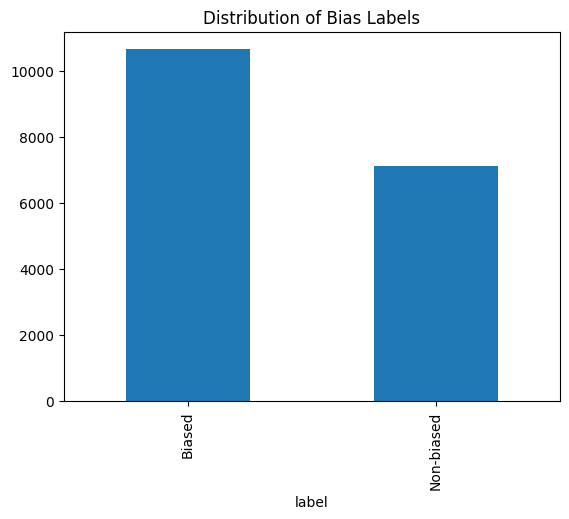

In [ ]:
df["label"].value_counts().plot(kind="bar", title="Distribution of Bias Labels")

### 3.2 Dynamics of bias and factuality

This bar graph visualized the relationship between bias labels (`biased` vs. `non-biased`) and factuality scores. By examining these variables, we explored how often headlines with different bias levels tend to align with varying degrees of factual reporting.

The graph reveals a clear **asymmetry**: biased headlines are mostly linked to opinion-driven or partially factual content, while unbiased headlines tend to be entirely factual.

This suggests that rhetorical bias is frequently accompanied by subjective or emotionally charged language, whereas neutral headlines tend to rely on objective reporting.


<Axes: title={'center': 'Bias vs. Factuality'}, xlabel='label'>

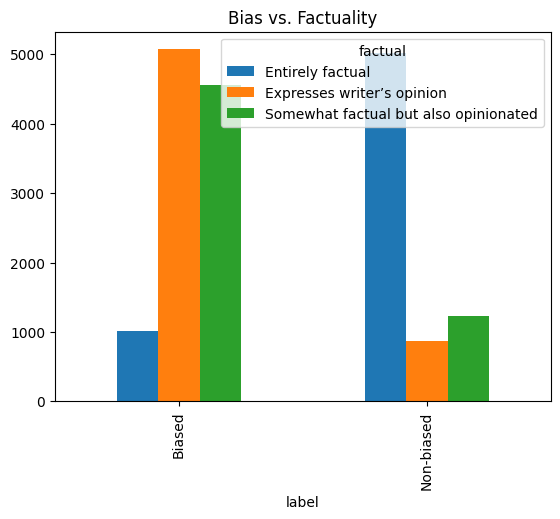

In [ ]:
pd.crosstab(df["label"], df["factual"]).plot(kind="bar", title="Bias vs. Factuality")

### 3.3 Distribution of ideological bias types

This horizontal bar graph visualizes the frequency of different ideological bias types present in the dataset. The type column categorizes headlines by their perceived political orientation: left, right, or center biased.

Understanding these categories allowed us to analyze how ideological framing manifests in media language and how to design features that capture directional bias in downstream classification tasks.

The graph reveals that headlines labeled as left and right biased occur with similar frequency, each approaching 7,000 instances. In contrast, center-type headlines are significantly less common, with fewer than 3,000 entries.

This distribution suggests that the **dataset emphasizes polarized content over neutral or centrist framing**. Such a skew may reflect the nature of contemporary media discourse, where ideological extremes are more likely to be flagged as rhetorically biased, either due to stronger emotional language or clearer partisan cues.

<Axes: title={'center': 'Types of Bias'}, ylabel='type'>

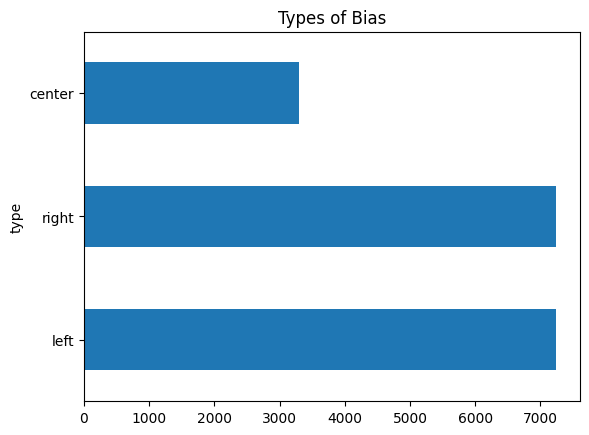

In [ ]:
df["type"].value_counts().plot(kind="barh", title="Types of Bias")

### 3.4 Media outlets in the MBIC Dataset
The bar graph below illustrates the distribution of media outlets represented in the dataset. These outlets span a broad ideological spectrum, enabling **comparative analysis of rhetorical bias across both political and stylistic boundaries**.

This selection includes left-leaning, right-leaning, and centrist outlets, providing a diverse foundation for downstream analysis of bias patterns, framing strategies, and emotional tone within political media discourse.

According to the **AllSides Media Bias Chart**, the outlets represented in the MBIC dataset can be categorized as follows:
- **Left**: AlterNet, Huffpost, MSNBC
- **Left-Leaning**: USA Today
- **Center**: Reuters
- **Right**: Breitbart, Federalist, Fox News

In [ ]:
print(df["outlet"].value_counts())

outlet
breitbart     3952
alternet      3531
msnbc         2522
federalist    2125
reuters       1661
usa-today     1638
huffpost      1191
fox-news      1155
Name: count, dtype: int64


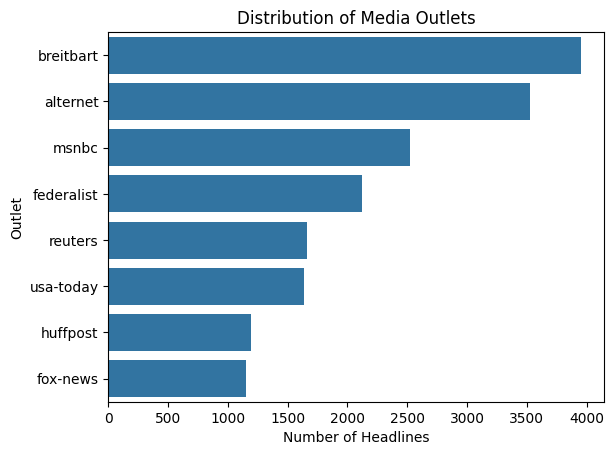

In [ ]:
sns.countplot(data=df, y="outlet", order=df["outlet"].value_counts().index)
plt.title("Distribution of Media Outlets")
plt.xlabel("Number of Headlines")
plt.ylabel("Outlet")
plt.show()

### 3.5 Topic Distribution in the MBIC Dataset

The dataset covers a wide range of politically and socially relevant topics, with relatively balanced representation across categories.

The most frequent topics include **environment** (1407), **white-nationalism** (1372), **gender** (1339), and **student-debt** (1332), all of which can be a part of emotionally and ideologically charged discourse.

Other prominent themes such as **abortion**, **gun-control**, **immigration**, and **vaccines** reflect ongoing public debates, while **trump-presidency** and **elections-2020** anchor the dataset in a specific political timeframe.

Although **international politics and world news** is the least represented category (922 headlines), it still offers meaningful contrast for analyzing cross-national framing strategies.

This distribution allows for nuanced analysis of bias across different domains, making it possible to compare rhetorical patterns between domestic and international coverage, as well as between culturally charged and policy-oriented topics.

In [ ]:
# Counting all topics in the MBIC dataset
print(df["topic"].value_counts())
# Lists all unique topic categories
print(df["topic"].unique())

topic
environment                              1407
white-nationalism                        1372
gender                                   1339
student-debt                             1332
sport                                    1320
abortion                                 1320
gun-control                              1296
immigration                              1276
coronavirus                              1275
vaccines                                 1275
trump-presidency                         1255
middle-class                             1227
elections-2020                           1159
international-politics-and-world-news     922
Name: count, dtype: int64
['gender' 'gun-control' 'white-nationalism' 'coronavirus'
 'trump-presidency' 'international-politics-and-world-news' 'middle-class'
 'sport' 'environment' 'abortion' 'elections-2020' 'vaccines'
 'student-debt' 'immigration']


### 3.6 Bias Label vs. Topic Analysis

To explore how rhetorical bias is distributed across  thematic domains, we examined the proportion of headlines labeled as biased within each topic category.

The results show that topics such as **abortion**, **gun-control**, **immigration**, and **white-nationalism** exhibit a higher share of biased headlines. In contrast, topics like **sport** or **middle-class** tend to show lower bias prevalence, suggesting more neutral or factual reporting.
Still, these topics have a high percentage of headlines labeled as biased, which leads to the conclusion, that we could not exclude any topics from the dataset for model training.

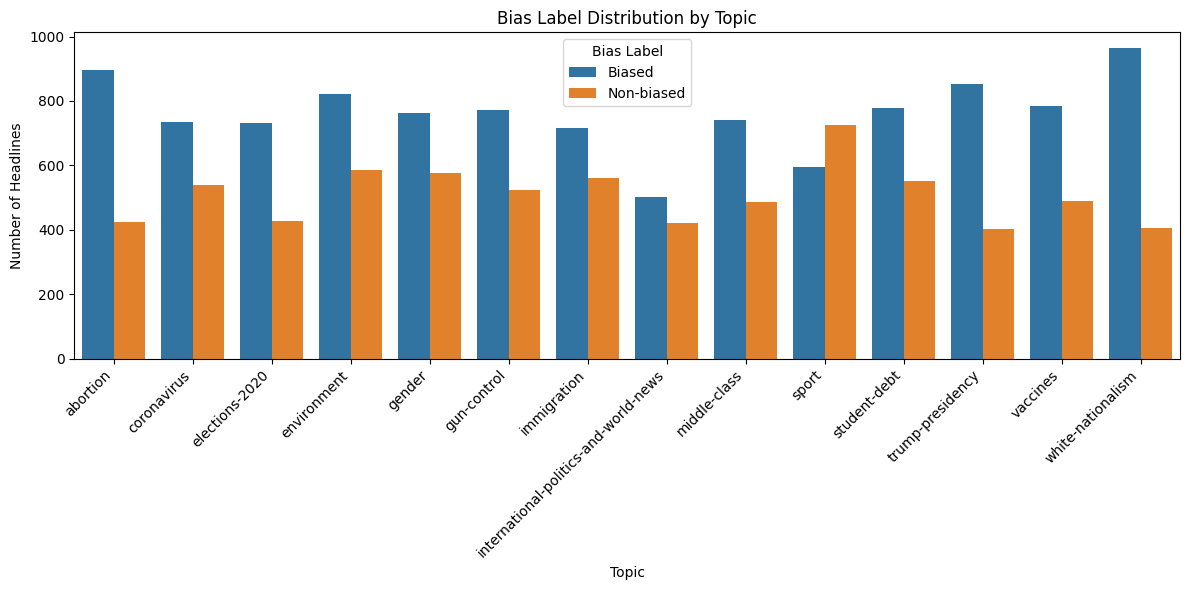

In [ ]:
# Group and count
bias_topic_counts = df.groupby(["topic", "label"]).size().reset_index(name="count")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=bias_topic_counts, x="topic", y="count", hue="label")
plt.xticks(rotation=45, ha="right")
plt.title("Bias Label Distribution by Topic")
plt.ylabel("Number of Headlines")
plt.xlabel("Topic")
plt.legend(title="Bias Label")
plt.tight_layout()
plt.show()

### 3.7 Political orientation of annotators

To better understand the ideological context of the annotations, we converted the continuous `political_ideology` scores into five categorical groups: **Far Left**, **Left**, **Center**, **Right**, **Far Right**. These bins were defined using quantile-based thresholds to ensure a more balanced distribution across ideological groups.

This conversion enabled a more interpretable analysis of how perceived bias may vary across different ideological positions. The resulting column, `ideology_group`, allows for stratified visualizations and comparative analysis across the political spectrum.

The resulting graph is **mostly balanced, with a slight left-leaning perspective**, which could affect how bias is perceived and labeld in the dataset.

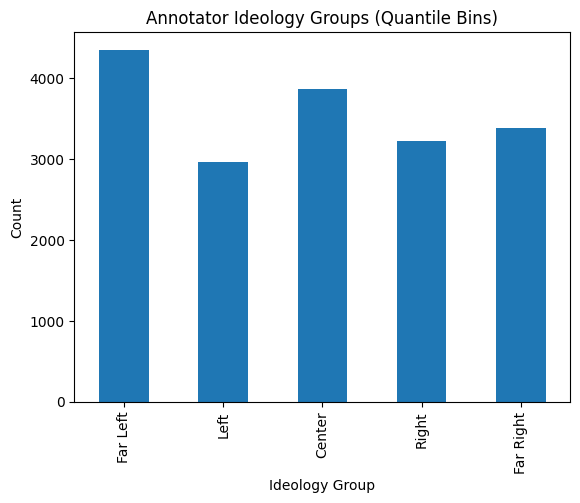

In [ ]:
df["political_ideology"] = pd.to_numeric(df["political_ideology"], errors="coerce")

df["ideology_group_quantile"] = pd.qcut(
    df["political_ideology"],
    q=5,
    labels=["Far Left", "Left", "Center", "Right", "Far Right"]
)

df["ideology_group_quantile"].value_counts().sort_index().plot(
    kind="bar", title="Annotator Ideology Groups (Quantile Bins)"
)
plt.ylabel("Count")
plt.xlabel("Ideology Group")
plt.show()

### 3.8 Relationship between Annotators' Political Orientation and Assignment of Bias

This graph reveals how the assignment of bias labels varies depending on the annotators' political orientation. Across all ideology groups, the number of biased labels exceeds the number of non-biased labels, but the extent of this difference varies significantly.

Annotators in the **Far Left** group assigned the highest number of labels overall, with a strong tendency to classify headlines as biased. This may reflect the political orientation of the annotators as seen above, where slightly more annotators self-report their political orientaiton as Far Left.

The **Center** group assigned the second highest number of bias labels, followed by the **Far Right** group, both leaning towards labeling headlines as biased, though with lower overall volume.

The **Left** and **Right** groups show similar patterns, both favoring the “biased” label, though with fewer total annotations.

This distribution suggests that bias perception is not ideologically neutral. Annotators with stronger political leanings, especially on the far ends of the spectrum as well as center, may be more likely to detect bias, possibly due to heightened awareness of ideological cues or differing thresholds for neutrality.






<Axes: title={'center': 'Bias Labels by Annotator Ideology'}, xlabel='ideology_group_quantile'>

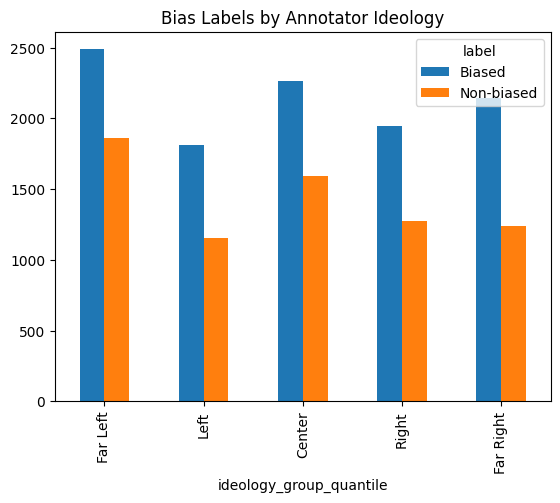

In [ ]:
pd.crosstab(df["ideology_group_quantile"], df["label"]).plot(kind="bar", title="Bias Labels by Annotator Ideology")

### 3.9 Headline length and text structure

Additionally, we examined the distribution of headline lengths by counting the number of words in each entry. This provides insight into the structural characteristics of the dataset's textual input, which consists primarily of short, compact headlines. Such shortness is typical of news headlines, where rhetorical density and emotional framing are often concentrated into just a few words.

The histogram reveals that most headlines range between 20 and 50 words, with a **peak around 30 to 35**. This suggests that while the dataset contains concise texts, they are not extremely short, indicating that many headlines include compound phrases, qualifiers, or emotionally charged language.

The left-skewed distribution, with fewer headlines exceeding 60 words, reinforces the idea that bias and framing are often embedded in concise, high-impact language.

<Axes: title={'center': 'Distribution of Headline Lengths'}, ylabel='Frequency'>

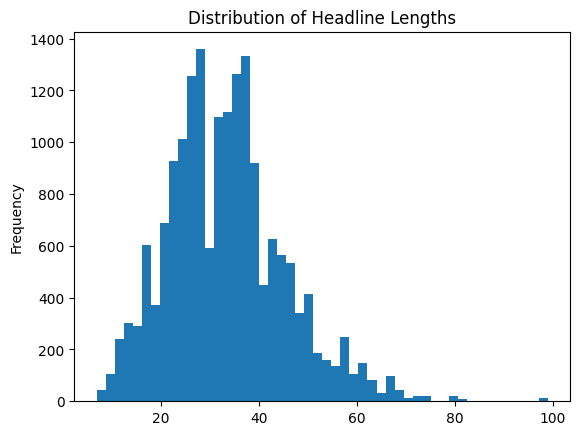

In [ ]:
df["text_length"] = df["text"].apply(lambda x: len(str(x).split()))
df["text_length"].plot(kind="hist", bins=50, title="Distribution of Headline Lengths")

### Modeling insights from EDA

The explorative data analysis of the MBIC dataset reveals several patterns relevant for bias classification. The **prevalence of biased headlines** suggests that opinionated framing is common, raising opportunities to explore linguistic markers such as emotional tone, length, and syntax.

**Factuality** emerges as a strong predictive feature, often distinguishing biased from unbiased content. **Topic diversity** and **ideological spread** across media outlets enable robust cross-domain comparisons, though centrist perspectives and global coverage remain underrepresented.

The slight **ideological imbalance** among annotators and headline sources highlights the need to account for subjectivity and potential skew in bias perception, especially through fairness-aware evaluation. The dataset's **short-form structure** supports transformer-based models, while syntactic features may enhance interpretability.

## 4. Baseline Model: Text-Only Bias Classification (DeBERTa-v3)

To evaluate the impact of engineered features (emotion and POS), we first trained a baseline model using only the original headline texts from the MBIC dataset. This model served as a reference point for assessing the added value of linguistic and emotional signals.

We used the `microsoft/deberta-v3-base` model, which we  also used afterwards with additional features.
Here, the raw headline text was the input and we used the `bias-binary` column (`biased` = 1 vs. `unbiased` = 0).

This baseline helped to enable a direct comparison with our feature-enhanced model to answer the question, to what extend additional features like emotional tone and political leaning can enhance the detection of rhetorical bias.

The text-only model was trained using stratified k-fold cross validation and evaluated with standard metrics:

- Accuracy  
- F1 Score  
- Precision
- Recall

This provided a transparent benchmark for understanding how much engineered features contributed to bias detection.


### 4.1 Random oversampling to balance the dataset (without additional features)

To address class imbalance between biased and unbiased headlines, we apply random oversampling to **balance the classes without reducing the dataset size**. This preserves all available information, which is especially important given the limited sample.

Steps:
- Separate biased and unbiased samples
- Determine the maximum class size
- Randomly oversample the smaller class with replacement
- Combine and shuffle to create a balanced dataset

This balanced set enables fairer model training, reduces bias toward the majority class and maintains data integrity by avoiding downsampling.



In [ ]:
df = df_subset[["text", "bias_binary"]].copy()

In [ ]:
# Separate the two classes
df_unbiased = df[df['bias_binary'] == 0]
df_biased = df[df['bias_binary'] == 1]

In [ ]:
# Find the max class size
max_size = max(len(df_unbiased), len(df_biased))

In [ ]:
# Oversample the smaller class
df_unbiased_oversampled = df_unbiased.sample(max_size, replace=True, random_state=42)
df_biased_oversampled = df_biased.sample(max_size, replace=True, random_state=42)

In [ ]:
# Combine back into a single balanced dataframe
df_balanced = pd.concat([df_unbiased_oversampled, df_biased_oversampled]).sample(frac=1, random_state=42)  # shuffle

print("Class distribution after balancing:")
print(df_balanced['bias_binary'].value_counts())

Class distribution after balancing:
bias_binary
0    10651
1    10651
Name: count, dtype: int64


### 4.2 Text-only model training

In [ ]:
# Select balanced dataset
texts = df_balanced["text"].tolist()
labels = df_balanced["bias_binary"].tolist()

In [ ]:
# Stratified K-Fold setup
set_seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [ ]:
# Custom Dataset class
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["bias_binary"] = torch.tensor(int(self.labels[idx]))
        return item

In [ ]:
# Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted")
    }

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)
    tokens["labels"] = examples["label"]  # wichtig!
    return tokens

In [ ]:
# Cross-validation loop
all_metrics = []
all_preds = []

def tokenize_function(examples):
    tokens = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128  # Headlines sind meist kurz
    )
    tokens["labels"] = examples["label"]  # wichtig für Trainer
    return tokens

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), start=1):
    print(f"\n===== Fold {fold} =====")

    # Split data
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]

    # Tokenize
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    # Datasets
    train_dataset = Dataset.from_dict({
        "text": train_texts,
        "label": train_labels
    }).map(tokenize_function, batched=True)

    val_dataset = Dataset.from_dict({
         "text": val_texts,
         "label": val_labels
    }).map(tokenize_function, batched=True)


    # Model
    model = DebertaV2ForSequenceClassification.from_pretrained(
        "microsoft/deberta-v3-base",
        num_labels=2
    )


    # Training setup
    output_dir = f"./results/fold{fold}"
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        logging_dir=f"./logs/fold{fold}",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=1e-5,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\nFold {fold} metrics:")
    print(metrics)
    all_metrics.append(metrics)

    # Save metrics for this fold
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{output_dir}/metrics.csv", index=False)

    # Predictions
    preds_output = trainer.predict(val_dataset)
    logits = preds_output.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(logits, axis=-1)

    fold_df = pd.DataFrame({
        "text": val_texts,
        "true_label": val_labels,
        "predicted_label": preds.tolist(),
        "probabilities": probs.tolist()
    })
    fold_df.to_csv(f"{output_dir}/predictions.csv", index=False)
    all_preds.append(fold_df)

    # Export SHAP-ready features - for future work with SHAP
    # features_df = pd.DataFrame(val_features, columns=feature_cols)
    # features_df.to_csv(f"{output_dir}/features.csv", index=False)

    # Combine predictions and features
    combined_df = pd.concat([fold_df], axis=1)
    combined_df.to_csv(f"{output_dir}/shap_ready.csv", index=False)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



===== Fold 1 =====


Map:   0%|          | 0/17041 [00:00<?, ? examples/s]

Map:   0%|          | 0/4261 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

/tmp/ipython-input-3925646927.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.552800,0.589361,0.697958,0.697944,0.697958,0.697994
2,0.528100,0.600794,0.709693,0.709626,0.709693,0.709890


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.552800,0.589361,0.697958,0.697944,0.697958,0.697994
2,0.528100,0.600794,0.709693,0.709626,0.709693,0.709890
3,0.554700,0.593198,0.706642,0.706472,0.706642,0.707113



Fold 1 metrics:
{'eval_loss': 0.6007936000823975, 'eval_accuracy': 0.7096925604318235, 'eval_f1': 0.709626029069697, 'eval_recall': 0.7096925604318235, 'eval_precision': 0.7098900051346729, 'eval_runtime': 43.7265, 'eval_samples_per_second': 97.447, 'eval_steps_per_second': 12.189, 'epoch': 3.0}

===== Fold 2 =====


Map:   0%|          | 0/17041 [00:00<?, ? examples/s]

Map:   0%|          | 0/4261 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3925646927.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.533300,0.579587,0.696785,0.693058,0.696785,0.706867
2,0.476500,0.568907,0.707346,0.707259,0.707346,0.707587
3,0.540000,0.577456,0.706642,0.706290,0.706642,0.707648



Fold 2 metrics:
{'eval_loss': 0.5689069628715515, 'eval_accuracy': 0.7073456934991786, 'eval_f1': 0.7072585936432938, 'eval_recall': 0.7073456934991786, 'eval_precision': 0.7075870594247617, 'eval_runtime': 43.6896, 'eval_samples_per_second': 97.529, 'eval_steps_per_second': 12.2, 'epoch': 3.0}

===== Fold 3 =====


Map:   0%|          | 0/17042 [00:00<?, ? examples/s]

Map:   0%|          | 0/4260 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3925646927.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.529100,0.574105,0.710563,0.710522,0.710563,0.710684
2,0.759200,0.578126,0.702582,0.701409,0.702582,0.705816
3,0.468400,0.595571,0.700704,0.699577,0.700704,0.703764



Fold 3 metrics:
{'eval_loss': 0.5741046071052551, 'eval_accuracy': 0.7105633802816902, 'eval_f1': 0.7105218909077923, 'eval_recall': 0.7105633802816902, 'eval_precision': 0.7106841652921433, 'eval_runtime': 43.7352, 'eval_samples_per_second': 97.404, 'eval_steps_per_second': 12.187, 'epoch': 3.0}

===== Fold 4 =====


Map:   0%|          | 0/17042 [00:00<?, ? examples/s]

Map:   0%|          | 0/4260 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3925646927.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.519500,0.602421,0.697653,0.694713,0.697653,0.705569
2,0.504200,0.573842,0.711268,0.710481,0.711268,0.713588
3,0.461100,0.591309,0.710329,0.708766,0.710329,0.714940



Fold 4 metrics:
{'eval_loss': 0.5738419890403748, 'eval_accuracy': 0.7112676056338029, 'eval_f1': 0.7104813508615939, 'eval_recall': 0.7112676056338029, 'eval_precision': 0.7135877936080092, 'eval_runtime': 43.7963, 'eval_samples_per_second': 97.269, 'eval_steps_per_second': 12.17, 'epoch': 3.0}

===== Fold 5 =====


Map:   0%|          | 0/17042 [00:00<?, ? examples/s]

Map:   0%|          | 0/4260 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3925646927.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.612700,0.594725,0.688498,0.685959,0.688498,0.694796
2,0.573400,0.588654,0.698826,0.698154,0.698826,0.700613
3,0.517300,0.600422,0.699296,0.698993,0.699296,0.700100



Fold 5 metrics:
{'eval_loss': 0.6004224419593811, 'eval_accuracy': 0.6992957746478873, 'eval_f1': 0.6989934843313683, 'eval_recall': 0.6992957746478873, 'eval_precision': 0.7000995867151322, 'eval_runtime': 43.7435, 'eval_samples_per_second': 97.386, 'eval_steps_per_second': 12.185, 'epoch': 3.0}


In [ ]:
# Save all metrics across folds
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv("./results/all_fold_metrics_nofeatures.csv", index=False)

# Combine all predictions
all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_csv("./results/all_predictions_nofeatures.csv", index=False)

### 4.3 Evaluation of text-only model

The **text-only model** demonstrates stable and reliable performance across all five folds. Each fold was trained for three epochs using the `microsoft/deberta-v3-base` backbone , with newly initialized classification layers. The model relies solely on headline text, without additional features.

**Fold 3** and **Fold 4** perfom best, with consistently high scores across all metrics. Precision is stable and slightly elevated, especially in Fold 4. The validation loss remains within a narrow range, indicating robust convergence.

The **consistent performance across all folds** confirms that the text-only model is reliable and capable of generalizing effectively from headline-level input




## 5. Emotion Detection
Following the training of our baseline model, we now turn to the emotional tone embedded in the headlines.Emotions play a crucial role in how information is framed, perceived, and interpreted, especially in politically charged contexts where language often serves to persuade, provoke, or polarize.

To quantify this emotional dimension, we used the transformer-based model `j-hartmann/emotion-english-distilroberta-base`, which is fine-tuned for emotion classification in English text.
It outputs scores across seven emotion categories: **anger**, **disgust**, **fear**, **joy**, **neutral**, **sadness**, and **surprise**.

Emotion scores were extracted in batch mode for efficiency and converted into a structured DataFrame. Each headline was assigned a dominant emotion label based on the highest score across seven categories and saved in a new column `dominant_emotion`.

In [28]:
emotion_model_name = "j-hartmann/emotion-english-distilroberta-base"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)
emotion_classifier = pipeline(
    "text-classification",
    model=emotion_model,
    tokenizer=emotion_tokenizer,
    return_all_scores=True,
    device=0
)

texts = df_subset["text"].tolist()
emotion_outputs = []
batch_size = 32

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    emotion_outputs.extend(emotion_classifier(batch))


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 556/556 [01:34<00:00,  5.87it/s]


In [29]:
# Convert outputs to DataFrame
def scores_to_dict(score_list):
    return {item["label"]: item["score"] for item in score_list}

emotion_dicts = [scores_to_dict(entry) for entry in emotion_outputs]
emotion_df = pd.DataFrame(emotion_dicts)

# Concatenate emotion scores with df_subset
df_subset = pd.concat([df_subset.reset_index(drop=True), emotion_df.reset_index(drop=True)], axis=1)

In [30]:
# Determine dominant emotion
df_subset["dominant_emotion"] = emotion_df.idxmax(axis=1)

### 5.1 Evaluation Emotion detection

To evaluate the model classification results, we reviewed the most frequent emotion overall in the new column `dominant_emotion` as well as the share of bias per emotion.

In [31]:
# Most frequent emotion
df_subset["dominant_emotion"].value_counts()

,count
dominant_emotion,
neutral,7885
disgust,2945
anger,2935
fear,2529
sadness,809
joy,361
surprise,311


In [32]:
# Share biased per Emotion
emotion_bias_rate = df_subset.groupby("dominant_emotion")["bias_binary"].value_counts(normalize=True).unstack()[1]
print(emotion_bias_rate.sort_values(ascending=False))

dominant_emotion
surprise    0.726688
disgust     0.693379
anger       0.600341
fear        0.586002
neutral     0.573367
sadness     0.536465
joy         0.509695
Name: 1, dtype: float64


While **neutral** dominates in overall frequency, the total comparison of share bias per emotion reveals that emotions such as **surprise** and **disgust** are disproportionately associated with biased annotations.

This confirms that emotional intensity, rather than frequency alone, plays a key role in bias perception. The high bias rates for “surprise” (72.7%) and “disgust” (69.3%) suggest that emotionally charged headlines may lead to stronger ideological sensitivity.


## 6. Political Leaning Classification

To complement the emotion detection, we estimated the ideological orientation of each headline using the transformer-based model `matous-volf/political-leaning-politics`.

This model classifies text into three categories: **left**, **center**, and **right**, based on linguistic and rhetorical patterns commonly found in political discourse.

While the dataset already includes bias annotations, this model-based classification provides an independent signal focused on ideological content rather than rhetorical framing. This distinction allows us to enrich the feature space, cross-validate annotations, and avoid conflating bias with political alignment.

Headlines were processed in batches using a HuggingFace pipeline with `return_all_scores=True`, capturing confidence scores across all three classes.

The final label was determined by selecting the class with the highest score and stored in a new column `predicted_leaning` for downstream analysis.

In [33]:
political_model_name = "matous-volf/political-leaning-politics"
political_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
political_model = AutoModelForSequenceClassification.from_pretrained(political_model_name)
political_classifier = pipeline(
    "text-classification",
    model=political_model,
    tokenizer=political_tokenizer,
    return_all_scores=True,
    device=0
)


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [34]:
political_outputs = []
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]
    political_outputs.extend(political_classifier(batch))

def extract_best_label(score_list):
    label_map = {"LABEL_0": "left", "LABEL_1": "center", "LABEL_2": "right"}
    best_label = max(score_list, key=lambda x: x["score"])["label"]
    return label_map[best_label]

df_subset["predicted_leaning"] = [extract_best_label(o) for o in political_outputs]


100%|██████████| 556/556 [02:39<00:00,  3.48it/s]


In [35]:
# Comparison annotated bias type vs. model classification
pd.crosstab(df_subset["type"], df_subset["predicted_leaning"])

predicted_leaning,center,left,right
type,,,
center,790,1892,617
left,716,5597,931
right,397,2854,3981


### 6.1 Evaluation political leaning

The cross-tabulation between annotated bias types and predicted ideological leanings reveals both **alignment and divergence**. Headlines labeled as “Left” show strong agreement with model predictions, while “Right”-labeled headlines are split between Left and Right predictions, suggesting potential ambiguity or annotator bias. “Center”-labeled headlines are frequently classified as Left by the model, indicating that perceived neutrality may still carry ideological signals.

## 7. Word-Level Politicization

Finally, the word-level analysis revealed how individual terms are distributed across biased and unbiased headlines. For each word, we computed its frequency in biased vs. non-biased contexts, the dominant emotion (`dominant_emotion`), and the dominant political leaning (`predicted_leaning`). Words that appear more often in biased texts were flagged as "**politicized**".

For example, the word **abandon** shows a higher frequency in biased headlines and is associated with a neutral tone and left-leaning context, suggesting it may carry subtle framing implications. In contrast, words like **abbott** or **abc** appear evenly or more frequently in unbiased texts, indicating less politicized usage.

This granular view supports the identification of ideologically charged vocabulary and can inform feature selection for bias detection models.

In [36]:
word_data = []
for doc_idx, doc in enumerate(nlp.pipe(df_subset["text"], disable=["ner"])):
    for token in doc:
        if not token.is_alpha or token.is_stop:
            continue
        word_data.append({
            "word": token.text.lower(),
            "POS": token.pos_,
            "sentence_idx": doc_idx
        })

words_df = pd.DataFrame(word_data)

In [37]:
# Merge with sentence-level emotion, political leaning
words_df = words_df.merge(
    df_subset[["dominant_emotion", "predicted_leaning", "bias_binary"]],
    left_on="sentence_idx",
    right_index=True,
    how="left"
)

In [38]:
# Compute frequencies for biased/unbiased contexts
word_stats = words_df.groupby("word").agg(
    freq_biased=("bias_binary", "sum"),
    freq_unbiased=("bias_binary", lambda x: (x == 0).sum()),
    top_emotion=("dominant_emotion", lambda x: x.value_counts().idxmax()),
    leaning_shift=("predicted_leaning", lambda x: x.value_counts().idxmax())
).reset_index()

# Flag words that appear more often in biased contexts
word_stats["politicized"] = np.where(word_stats["freq_biased"] > word_stats["freq_unbiased"], "yes", "no")

# Preview
word_stats.head()

,word,freq_biased,freq_unbiased,top_emotion,leaning_shift,politicized
0,aaron,4,6,neutral,left,no
1,abandon,14,7,neutral,left,yes
2,abandoned,6,14,disgust,right,no
3,abbott,6,17,surprise,left,no
4,abc,5,5,disgust,left,no


### 7.1 Document-Level Politicization Score

To quantify the presence of politically charged language at document level, we computed a politicization score for each headline. This score reflects the number of words in a headline that appear more frequently in biased contexts, based on prior word-level analysis.

Using spaCy, each headline was tokenized and filtered for meaningful content words. The score was then calculated by counting how many of these words are part of the previously identified set of politicized terms.

This metric provides a simple yet interpretable signal for downstream tasks such as **bias classification**, **thresholding**, or **exploratory analysis** of political **framing intensity** across topics or outlets.

In [39]:
# Get set of politicized words
politicized_words = set(word_stats.loc[word_stats["politicized"] == "yes", "word"])


In [40]:
# Count politicized words per document
scores = []
for doc in tqdm(nlp.pipe(texts, disable=["ner"]), total=len(texts)):
    tokens = [t.text.lower() for t in doc if t.is_alpha and not t.is_stop]
    score = sum(1 for t in tokens if t in politicized_words)
    scores.append(score)

100%|██████████| 17775/17775 [00:52<00:00, 340.15it/s]


In [41]:
# Assign politicization score to each document based on frequency of biased words
df_subset["politicization_score"] = scores

### 7.2 Evaluation document-level politication scores
Headlines labeled as “Biased” exhibit a higher average politicization score (15.87) compared to “Non-biased” headlines (12.27). This suggests that the presence of ideologically charged language contributes to bias perception, reinforcing the link between lexical framing and annotation outcomes.

In [44]:
# Average score per bias label
df_subset.groupby("bias_binary")["politicization_score"].mean()

,politicization_score
bias_binary,
0,12.27288
1,15.87297


## 8. Correlation Analysis

In this section, we explore the relationships between key variables in the dataset to uncover potential dependencies that may inform bias classification. By examining how the features **emotional tone** and **political leaning** relate to perceived bias, we aim to identify patterns that could support feature selection and model design to provide a statistical foundation for interpreting rhetorical framing.

### 8.1 Pearsons correlation

We apply Pearson correlation, a statistical measure that captures the strength and direction of **linear relationships** between numerical variables. To enable this, categorical features like `dominant_emotion` and `predicted_leaning` were first encoded numerically. We then computed their correlation with the binary bias label (`bias_binary`) and `politicization_score`.

The resulting correlation matrix is visualized as a heatmap, allowing for quick identification of potential dependencies or independence between features. While weak correlations suggest limited linear relationships, this analysis provides a foundation for deeper, non-linear modeling and feature selection.

The correlation analysis shows:

- **Politicization vs. Bias**: Moderate correlation (r = 0.27) suggests that headlines with more politicized vocabulary are more likely to be labeled as biased.  
- **Bias vs. Ideology**: Very weak correlation (r ≈ 0.05), indicating that perceived bias is largely independent of political leaning.  
- **Bias vs. Emotion**: No meaningful linear relationship (r ≈ –0.05), though finer emotional distinctions may reveal more.  
- **Politicization vs. Emotion**: Slight negative correlation (r = –0.13), implying that emotionally expressive and politically charged language may function separately.

These findings support the idea that rhetorical bias is more closely tied to politicized word choice than to ideological stance or emotional tone.
This opened the possibility for **non-linear modeling**, and indicated that emotion and political leaning may capture distinct and complementary signals in bias classification.



In [46]:
# Encode categorical features numerically
df_subset["dominant_emotion_num"] = LabelEncoder().fit_transform(df_subset["dominant_emotion"])
df_subset["political_leaning_num"] = LabelEncoder().fit_transform(df_subset["predicted_leaning"])


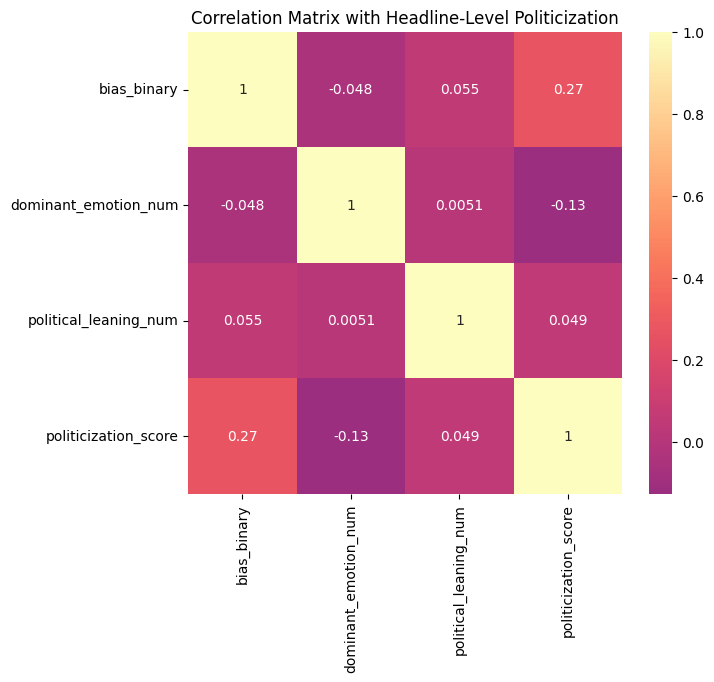

In [47]:
features = df_subset[[
    "bias_binary",
    "dominant_emotion_num",
    "political_leaning_num",
    "politicization_score"
]]

corr_matrix = features.corr()
plt.figure(figsize=(7,6))
sns.heatmap(corr_matrix, annot=True, cmap="magma", center=0)
plt.title("Correlation Matrix with Headline-Level Politicization")
plt.show()

### 8.2 Chi-Square test

While Pearson correlation captures linear relationships between numerical variables, the Chi-Square test evaluates whether two categorical variables are statistically dependent.

In this section, we applied the Chi-Square test to assess whether features such as bias, dominant emotion, political leaning and politicization score are significantly associated. This approach helps uncover hidden dependencies that may be missed by linear metrics and informs feature selection for classification tasks.

The results reveal highly significant associations:
- **Bias vs Emotion**: χ² = 178.87, p < 0.001  
- **Bias vs Political Leaning**: χ² = 83.93, p < 0.001  
- **Emotion vs Political Leaning**: χ² = 120.42, p < 0.001
- **Bias vs Politicization Score**: χ² = 1313.91, p < 0.0001


These findings suggest that **emotional tone**, **ideological alignment**, and **politicization score** are not independent of perceived bias. Each variable contributes distinct, non-linear signals that shape how bias is detected and annotated. The exceptionally strong association between politicization score and bias annotation suggests that ideologically charged language plays a central role in bias perception.

Together, these results support the integration of emotional and ideological features into bias-aware modeling pipelines, enhancing interpretability and classification performance.

In [48]:
# Bias vs Emotion
contingency_emotion = pd.crosstab(df_subset["bias_binary"], df_subset["dominant_emotion"])
chi2_emotion, p_emotion, _, _ = chi2_contingency(contingency_emotion)

# Bias vs Political Leaning
contingency_political = pd.crosstab(df_subset["bias_binary"], df_subset["predicted_leaning"])
chi2_political, p_political, _, _ = chi2_contingency(contingency_political)

# Emotion vs Political Leaning
contingency_emotion_political = pd.crosstab(df_subset["dominant_emotion"], df_subset["predicted_leaning"])
chi2_emotion_political, p_emotion_political, _, _ = chi2_contingency(contingency_emotion_political)

# Bias vs Politicization Score
# Categorize politicization_score into bins for Chi-Square test
df_subset["politicization_score_binned"] = pd.qcut(df_subset["politicization_score"], q=4, labels=False, duplicates='drop')

contingency_politicization = pd.crosstab(df_subset["bias_binary"], df_subset["politicization_score_binned"])
chi2_politicization, p_politicization, _, _ = chi2_contingency(contingency_politicization)

# Print results
print(f"Bias vs Emotion: Chi² = {chi2_emotion:.2f}, p = {p_emotion:.4f}")
print(f"Bias vs Political Leaning: Chi² = {chi2_political:.2f}, p = {p_political:.4f}")
print(f"Emotion vs Political Leaning: Chi² = {chi2_emotion_political:.2f}, p = {p_emotion_political:.4f}")
print(f"Bias vs Politicization Score: Chi² = {chi2_politicization:.2f}, p = {p_politicization:.4f}")

Bias vs Emotion: Chi² = 178.87, p = 0.0000
Bias vs Political Leaning: Chi² = 83.93, p = 0.0000
Emotion vs Political Leaning: Chi² = 120.42, p = 0.0000
Bias vs Politicization Score: Chi² = 1313.91, p = 0.0000


In [ ]:
with open("/content/drive/MyDrive/NLP Project 2025/Notebook Model/df_subset_final.pkl", "wb") as f:
    pickle.dump(df_subset, f)

## 11. DeBERTa-v3 Bias Classifier with Statified K Fold Cross Validation

Building on these findings, we fine-tuned a transformer-based classifier leveraging the `microsoft/deberta-v3-base` architecture, consistent with the configuration employed in the text-only baseline model.

As in previous experiments, we applied **Stratified K-Fold Cross Validation** to ensure robust evaluation while preserving class distribution across folds, a critical consideration given the imbalance between biased and non-biased samples.

The classifier was trained on an **extended feature set** consisting of raw headline text, emotion scores, and predicted political leaning. We derived a new target label `label_direction`, which distinguished between biased headlines by their predicted leaning (`left`, `center`, `right`) and labels unbiased ones as `unbiased`.
This categorical label was then encoded numerically (`label_encoded`) for **downstream modeling**.

**Evaluation metrics** include accuracy, precision, recall, and F1-score, consistent with the baseline setup.
This approach enables reliable performance assessment and supports a more nuanced modeling of bias by incorporating affective and ideological signals into the classification pipeline.

### 11.1 Random oversampling to balance the dataset (with additional features)

Similar to the random oversampling for the text-only baseline classification model, the steps were:

- **Separate** biased and unbiased samples
- **Determine** the maximum class size
- **Randomly oversample** the smaller class with replacement
- **Combine and shuffle** to create a balanced dataset


In [ ]:
# Separate the two classes
df_unbiased = df_subset[df_subset['bias_binary'] == 0]
df_biased = df_subset[df_subset['bias_binary'] == 1]

In [ ]:
# Find the max class size
max_size = max(len(df_unbiased), len(df_biased))

In [ ]:
# Oversample the smaller class
df_unbiased_oversampled = df_unbiased.sample(max_size, replace=True, random_state=42)
df_biased_oversampled = df_biased.sample(max_size, replace=True, random_state=42)

In [ ]:
# Combine back into a single balanced dataframe
df_balanced = pd.concat([df_unbiased_oversampled, df_biased_oversampled]).sample(frac=1, random_state=42)  # shuffle

print("Class distribution after balancing:")
print(df_balanced['bias_binary'].value_counts())

Class distribution after balancing:
bias_binary
0    10651
1    10651
Name: count, dtype: int64


### 11.2 Feature Engineering: Emotion and Political Leaning

To enrich the feature space, we included **emotion scores** and predicted **political leaning** indicators for each headline. Emotion scores (`anger`, `disgust`, `fear`, etc.) capture affective framing, while leaning labels (`LABEL_left`, `LABEL_right`, etc.) reflect ideological cues.

These features support **multi-class classification** and enable a more nuanced analysis of rhetorical bias by bridging emotional framing and ideological orientation.

In [ ]:
# Including emotion and political leaning scores as additional features
emotion_cols = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
leaning_cols = [col for col in df_balanced.columns if col.startswith('LABEL_')]
feature_cols = emotion_cols + leaning_cols

df_balanced["label_direction"] = df_balanced.apply(lambda x: x["predicted_leaning"] if x["bias_binary"]==1 else "unbiased", axis=1)
label_encoder = LabelEncoder()
df_balanced["label_encoded"] = label_encoder.fit_transform(df_balanced["label_direction"])

### 11.3 Feature-enhanced model training

In [ ]:
# Select balanced dataset
texts = df_balanced["text"].tolist()
labels = df_balanced["label_encoded"].tolist()
features = df_balanced[feature_cols].values.tolist()

In [ ]:
# Stratified K-Fold setup
set_seed(42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

In [ ]:
# Custom Dataset class
class BiasDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, features):
        self.encodings = encodings
        self.labels = labels
        self.features = features
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["features"] = torch.tensor(self.features[idx], dtype=torch.float)
        return item

In [ ]:
# Metric function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted")
    }

In [ ]:
# Cross-validation loop
all_metrics = []
all_preds = []

for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels), start=1):
    print(f"\n===== Fold {fold} =====")

    # Split data
    train_texts = [texts[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    train_labels = [labels[i] for i in train_idx]
    val_labels = [labels[i] for i in val_idx]
    train_features = [features[i] for i in train_idx]
    val_features = [features[i] for i in val_idx]

    # Tokenize
    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    # Datasets
    train_dataset = BiasDataset(train_encodings, train_labels, train_features)
    val_dataset = BiasDataset(val_encodings, val_labels, val_features)

    # Model
    model = DebertaV2ForSequenceClassification.from_pretrained(
        "microsoft/deberta-v3-base",
        num_labels=len(label_encoder.classes_)
    )

    # Training setup
    output_dir = f"./results/fold{fold}"
    os.makedirs(output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        eval_strategy="epoch",
        logging_dir=f"./logs/fold{fold}",
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=2,
        learning_rate=1e-5,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train and evaluate
    trainer.train()
    metrics = trainer.evaluate()
    print(f"\nFold {fold} metrics:")
    print(metrics)
    all_metrics.append(metrics)

    # Save metrics for this fold
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv(f"{output_dir}/metrics.csv", index=False)

    # Predictions
    preds_output = trainer.predict(val_dataset)
    logits = preds_output.predictions
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = np.argmax(logits, axis=-1)

    fold_df = pd.DataFrame({
        "text": val_texts,
        "true_label": val_labels,
        "predicted_label": preds.tolist(),
        "probabilities": probs.tolist()
    })
    fold_df.to_csv(f"{output_dir}/predictions.csv", index=False)
    all_preds.append(fold_df)

    # Export SHAP-ready features
    features_df = pd.DataFrame(val_features, columns=feature_cols)
    features_df.to_csv(f"{output_dir}/features.csv", index=False)

    # Combine predictions and features
    combined_df = pd.concat([fold_df, features_df], axis=1)
    combined_df.to_csv(f"{output_dir}/shap_ready.csv", index=False)


===== Fold 1 =====


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4256143857.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.769100,0.758050,0.681061,0.663156,0.681061,0.656986


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.769100,0.758050,0.681061,0.663156,0.681061,0.656986
2,0.608700,0.675270,0.695611,0.695089,0.695611,0.697499
3,0.568800,0.647725,0.705234,0.705416,0.705234,0.706036



Fold 1 metrics:
{'eval_loss': 0.6477251052856445, 'eval_accuracy': 0.7052335132597982, 'eval_f1': 0.7054157373882404, 'eval_recall': 0.7052335132597982, 'eval_precision': 0.7060356291562331, 'eval_runtime': 39.3121, 'eval_samples_per_second': 108.389, 'eval_steps_per_second': 13.558, 'epoch': 3.0}

===== Fold 2 =====


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4256143857.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.774300,0.745389,0.683408,0.671326,0.683408,0.681343
2,0.633500,0.677809,0.701244,0.700603,0.701244,0.700498
3,0.547000,0.659430,0.700540,0.700525,0.700540,0.700626



Fold 2 metrics:
{'eval_loss': 0.6778094172477722, 'eval_accuracy': 0.7012438394743018, 'eval_f1': 0.7006029804103481, 'eval_recall': 0.7012438394743018, 'eval_precision': 0.7004980526989933, 'eval_runtime': 38.1785, 'eval_samples_per_second': 111.607, 'eval_steps_per_second': 13.961, 'epoch': 3.0}

===== Fold 3 =====


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4256143857.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.791500,0.714958,0.685915,0.669818,0.685915,0.655078
2,0.567500,0.627078,0.712911,0.712204,0.712911,0.717655
3,0.498500,0.604717,0.717840,0.718167,0.717840,0.719433


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Fold 3 metrics:
{'eval_loss': 0.6047167778015137, 'eval_accuracy': 0.7178403755868544, 'eval_f1': 0.7181666621291514, 'eval_recall': 0.7178403755868544, 'eval_precision': 0.7194327590390928, 'eval_runtime': 37.8999, 'eval_samples_per_second': 112.401, 'eval_steps_per_second': 14.063, 'epoch': 3.0}

===== Fold 4 =====


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4256143857.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.828100,0.766641,0.674178,0.658193,0.674178,0.680897
2,0.592400,0.659315,0.705634,0.704712,0.705634,0.706205
3,0.625300,0.639486,0.709390,0.709000,0.709390,0.709310



Fold 4 metrics:
{'eval_loss': 0.6394861340522766, 'eval_accuracy': 0.7093896713615023, 'eval_f1': 0.7089998969492156, 'eval_recall': 0.7093896713615023, 'eval_precision': 0.7093103612597724, 'eval_runtime': 37.6333, 'eval_samples_per_second': 113.198, 'eval_steps_per_second': 14.163, 'epoch': 3.0}

===== Fold 5 =====


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4256143857.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall,Precision
1,0.756500,0.728817,0.674413,0.664538,0.674413,0.678510
2,0.541600,0.645078,0.703756,0.703048,0.703756,0.705239
3,0.707400,0.634279,0.705869,0.705734,0.705869,0.707068



Fold 5 metrics:
{'eval_loss': 0.6342791318893433, 'eval_accuracy': 0.705868544600939, 'eval_f1': 0.7057336770870664, 'eval_recall': 0.705868544600939, 'eval_precision': 0.7070677669518027, 'eval_runtime': 38.0111, 'eval_samples_per_second': 112.073, 'eval_steps_per_second': 14.022, 'epoch': 3.0}


In [ ]:
# Save all metrics across folds
all_metrics_df = pd.DataFrame(all_metrics)
all_metrics_df.to_csv("./results/all_fold_metrics_withfeatures.csv", index=False)

# Combine all predictions
all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_csv("./results/all_predictions_withfeatures.csv", index=False)

### 11.4 Evaluation of feature-enhanced model

Across all five folds, the feature-enhanced model demonstrates **consistent performance with minor fluctuations in key metrics**. Each fold was trained for three epochs using the `microsoft/deberta-v3-base` backbone, with newly initialized classification layers.

**Fold 3** stands out with the best overall performance, suggesting that feature interactions were especially effective within the structure of this fold. **Precision** remains **stable** across folds, indicating reliable positive class predictions. The **validation loss varies**, with Fold 2 showing the weakest generalization.

Overall, the **model demonstrates consistent performance** across all folds, suggesting a **high degree of robustness and generalizability** within the feature-enhanced configuration.

## 12. Evaluation and Performance comparison: Text-only Model vs. Feature-Enhanced Model

This section shows a comparative evaluation of the text-only and feature-enhanced models. For each, we computed the **mean** and **standard deviation** of key metrics (`eval_accuracy`, `eval_f1`, `eval_precision`, `eval_recall`, and `eval_loss`), aggregated across five cross-validation folds.

We first retrieved the CSV files produced during training, each containing key performance metrics. These were parsed into dataframes for systematic analysis.


In [ ]:
# Load csv of model without additional features
df_without = pd.read_csv("/content/all_fold_metrics_nofeatures.csv")
# If you load the file directly from the local folder after creating the csv:
# df_without = pd.read_csv("content/results/all_fold_metrics_nofeatures.csv")

In [ ]:
# Calculate mean values and standard deviations
metrics = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "eval_loss"]

# Mean
mean_values = df_without[metrics].mean()

# Standard derivation
std_values = df_without[metrics].std()

# Output
print("Mittelwerte:")
print(mean_values.round(4))

print("\nStandardabweichungen:")
print(std_values.round(4))

Mittelwerte:
eval_accuracy     0.7076
eval_f1           0.7074
eval_precision    0.7084
eval_recall       0.7076
eval_loss         0.5836
dtype: float64

Standardabweichungen:
eval_accuracy     0.0049
eval_f1           0.0049
eval_precision    0.0051
eval_recall       0.0049
eval_loss         0.0157
dtype: float64


In [ ]:
# Load csv of model without additional features
df_with = pd.read_csv("/content/all_fold_metrics_withfeatures.csv")
# If you load the file directly from the local folder after creating the csv:
# df_with = pd.read_csv("content/results/all_fold_metrics_withfeatures.csv")

In [ ]:
# Calculate mean values and standard deviations
metrics = ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall", "eval_loss"]

# Mean
mean_values = df_with[metrics].mean()

# Standard derivation
std_values = df_with[metrics].std()

# Output
print("Mittelwerte:")
print(mean_values.round(4))

print("\nStandardabweichungen:")
print(std_values.round(4))

Mittelwerte:
eval_accuracy     0.7079
eval_f1           0.7078
eval_precision    0.7085
eval_recall       0.7079
eval_loss         0.6408
dtype: float64

Standardabweichungen:
eval_accuracy     0.0063
eval_f1           0.0065
eval_precision    0.0069
eval_recall       0.0063
eval_loss         0.0263
dtype: float64


### Performance Comparison: Text-only Model vs. Feature-Enhanced Model

The following table depicts the combined results from the text-only model and the feature-enhanced model:

| Metric         | Text-only Mean | Feature Mean | Text-only Std | Feature Std |
|----------------|----------------|--------------|----------------|-------------|
| Accuracy       | 0.7076         | 0.7079       | 0.0049         | 0.0063      |
| F1 Score       | 0.7074         | 0.7078       | 0.0049         | 0.0065      |
| Precision      | 0.7084         | 0.7085       | 0.0051         | 0.0069      |
| Recall         | 0.7076         | 0.7079       | 0.0049         | 0.0063      |
| Eval Loss      | 0.5836         | 0.6408       | 0.0157         | 0.0263      |

The **feature-enhanced model** showed slightly higher mean values for accuracy, F1, and recall, but the differences were marginal.
The **text-only model** achieved lower evaluation loss and exhibited less variance across folds, suggesting more stable performance.
Precision was nearly identical across both models, though the feature model showed slightly more variability.

This baseline helped to enable a direct comparison with our feature-enhanced model to answer the question, to what extend additional features like emotional tone and political leaning can enhance the detection of rhetorical bias.

These results suggest that while additional features may offer incremental improvements in certain folds, the `microsoft/deberta-v3-base` model fine-tuned on text alone remains competitive and robust. Further analysis (e.g. interpretability with `SHAP` or `LIME`) could help clarify which other features could contribute meaningfully.


# Summary: What We've Achieved

In this notebook, we developed a modular and interpretable pipeline to detect rhetorical bias in news headlines. We started by training a model on text-only input as a baseline. For the feature-enhanced model, we classified emotion and political leaning of the datasets, before turning to word-level- and document-level-politicization.

Through correlation analysis, we revealed structural patterns of bias across headlines. To evaluate predictive performance with additional features, we trained the `microsoft/deberta-v3-base` a second time.

Both models were validated using Stratified K-Fold Cross Validation, ensuring balanced class representation across folds and mitigating the effects of class imbalance through random oversampling.

The result is a reproducible, insight-driven workflow that bridges statistical analysis, linguistic framing, and modern NLP, ready to support further research, visualization, or deployment.

